<a href="https://colab.research.google.com/github/legalnlp21/legalnlp/blob/main/demo/Doc2Vec/Doc2Vec_TUTORIAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução

Um dos grandes desafios de algoritmos de ciência da computação é a representação numérica de textos e documentos, por isso novas abordagens são essenciais para que possamos concretamente analisar novas formas de realizar uma representação vetorial de documentos sem a perda de sentido entre as palavras. Neste sentido, apresentamos uma breve explicação de um modelo que é visto como uma extensão do Word2Vec, previamente descrito, denominado **Doc2Vec** ou **Paragraph Vector** - Vetor de Parágrafos.

Proposto por Tomas Mikolov e Quoc Le, ambos funcionários do Google na época do desenvolvimento do modelo (2014), o artigo original pode ser encontrado e lido aqui: [Distributed Representations of Sentences and Documents](https://arxiv.org/pdf/1405.4053.pdf).

##O que é o Doc2Vec e como funciona

Como dito acima, o Doc2Vec, também chamado de $\textit{Paragraph Vector}$ (Vetor de Paragráfos), pode ser visto como uma extensão do Word2Vec no sentido de, no caso do Word2Vec, cujo objetivo é a representação de palavras no espaço real d-dimensional ($R^d$, $\,$ $d \in \textbf{Z}^{+}$), ser utilizado para a representação de documentos no espaço d-dimensional.

O Vetor de Paragráfos é um algoritmo não supervisionado que aprende representações vetoriais diferentes para as palavras de variados textos. Apesar do seu nome, ele enfatiza o fato que podemos utilizá-lo para textos de diversos tamanhos, desde simples sentenças até enormes documentos.

Agora veremos brevemente a estrutura do Vetor de Parágrafos.

## Estrutura do Doc2Vec

O Doc2Vec possui duas variações: PV-DM e DBOW, possuindo algumas semelhanças com o Word2Vec. Explicaremos brevemente como essas variações funcionam abaixo. 

### PV-DM: Paragraph Vector - Distributed Memory

Essa abordagem se assemelha ao CBOW (Continuous Bag-Of-Words) do Word2Vec, uma vez que recebe como entrada as palavras de contexto (uma vizinhança da palavra $\textit{target}$) e retorna a palavra com maior probabilidade de pertencer àquele contexto. Porém uma diferença se torna presente: a presença de uma matriz de paragráfos (representada por D na figura abaixo), realizando o mapeamento dos paragráfos para vetores distintos de palavras. Representando a informação perdida de um determinado contexto.

Assim, cada parágrafo é mapeado para um único vetor, que representa uma coluna em **D** e cada palavra também é mapeada para um único vetor, que representa cada coluna em **W**. Depois disso, é feita a média ou concatenação desses vetores para a predição da próxima palavra no contexto, que possuem tamanho fixo e são escolhidos a partir de um tamaho de janela especificado que percorre o parágrafo.



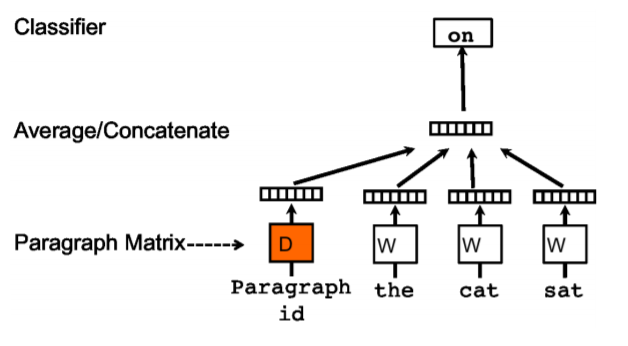

O token de parágrafos funciona memorizando o que está faltando do contexto e por isso o nome Distributed Memory.  

Durante cada etapa do treinamento, um contexto de tamanho fixo é selecionado aleatoriamente de um parágrafo e é calculado o erro para o ajuste dos parâmetros do modelo.

Para a predição, é necessário um vetor de parágrafos de teste para calcular para um outro vetor de parágrafos novo, e então feita a inferência nesse conjunto de teste nunca antes visto pelo modelo. Nesta fase, os parâmetros do modelo e os vetores de palavras **W** estão fixos.

Após o treinamento, o Vetor de Parágrafos pode ser utilizado como *features* em modelos convencionais, como a Regressão Logística, CatBoost, Florestas Aleatórias, XGBoost, etc. 

Algumas vatangens dos Vetores de Parágrafos são o fato deles utilizarem dados não rotulados e fornecerem uma boa generalização do modelo de Skip-Gram para altas dimensões, preservando a semântica e a ordem das palavras. 


### PV-DBOW: Paragraph Vector - Distributed Bag-Of-Words

Essa abordagem, por sua vez, é semelhante ao Skip-Gram do Word2Vec, ou seja, no caso desse modelo, dado uma palavra, o objetivo é prever o contexto. No DBOW, é utilizado o Vetor de Paragráfos para prever a vizinhança de uma determinada palavra, em uma janela fixa.

E também pode ser visto como o modelo acima, sendo que os vetores de palavras **W** são ignorados durante o processo de treinamento e o modleo é forçado a prever palavras escolhidas aleatoriamente do parágrafo.



A imagem abaixo representa um esquema simplificado de como PV-DBOW atua.

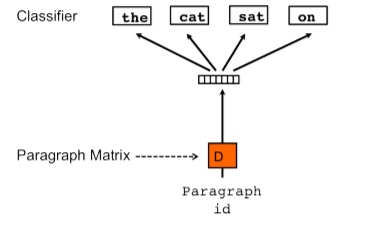

Como vantagem, essa abordagem requere menos armazenamento, sendo assim mais eficiente, uma vez que os vetores de palavras são ignorados.

#Mão na massa

Agora vamos ver uma aplicação do Doc2Vec em uma tarefa de classificação com um conjunto de dados de textos jurídicos com seus status: Ativo, Suspenso ou Arquivado. Comecemos com a parte brevemente descritiva e de pré-processamento dos dados. 

##Importando

Vamos importar as bibliotecas necessárias para a utilização do modelo.

In [1]:
from google.colab import drive
from IPython.display import clear_output

import re
!pip install ftfy
import ftfy

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

!pip install git+https://github.com/legalnlp21/legalnlp
from legalnlp.clean_functions import *
clear_output()

Célula de comando para fazer o download do modelo Doc2Vec pré-treinado.

In [2]:
from legalnlp.get_premodel import *
get_premodel('wodc')

True

Aqui vamos importar o conjunto de dados no qual iremos trabalhar neste tutorial:

In [3]:
data=pd.read_csv('https://raw.githubusercontent.com/legalnlp21/legalnlp/main/demo/data_base.csv')
data.drop(columns=['Unnamed: 0'],inplace=True)

E uma breve visualização desses dados:

In [4]:
data.head()

,text,label
0,Início da Execução Juntado 0008003-11.2018.8.2...,H:Suspenso
1,Ofício Requisitório - Comunicação - Protocolo ...,H:Arquivado
2,Arquivado Provisoriamente aguardando manifestação,H:Suspenso
3,Petição Juntada Juntada a petição diversa - Ti...,H:Ativo
4,Remetidos os Autos para o Arquivo Geral – Devo...,H:Arquivado


Esse conjunto de dados possui 6449 observações e 2 variáveis.

Vamos ver agora se temos dados faltantes:

In [5]:
print("Quantidade de dados faltantes: ", data.isna().any().sum())

Quantidade de dados faltantes:  0


Isso é bom.Não temos nenhum dado faltante! Porém, vemos que os dados precisam ser limpos antes de serem aplicados no modelo, então vamos aplicar um função que limpa essas observações da coluna $text$.

Aplicamos então a função de limpeza na coluna $text$:

In [6]:
data['text'] = data['text'].apply(lambda x: clean(x))

E obtemos os dados agora limpos, vamos dar uma olhada:

In [7]:
str(data.loc[1,'text'])

'ofício requisitório - - comunicação - - protocolo eletrônico - - depre'

## Carregando o Modelo

Agora vamos carregar o modelo Doc2Vec pré-treinado, com abordagem PV-DBOW, de tamanho: $size = 100$ e tamanho de janela: $window\_size = 15$.

In [8]:
model = Doc2Vec.load('/content/W2V_D2V/w2v_d2v_dbow_size_100_window_15_epochs_20')

Com o modelo carregado, podemos utilizar alguns métodos fornecidos na documentação da biblioteca [Gensim](https://radimrehurek.com/gensim/models/doc2vec.html) para o Doc2Vec.

Com o modelo pré-treinado, podemos inferir novos vetores para novas senteças. 

In [9]:
model.infer_vector("Textos Jurídicos")

array([-0.10159062, -0.18378945, -0.03486342, -0.26060516,  0.16852371,
        0.15712844, -0.3058182 , -0.0092575 ,  0.17853624, -0.10572945,
        0.02244192, -0.08772123, -0.01747082, -0.06555123,  0.31511003,
       -0.09416669, -0.21966097,  0.10628534,  0.02560714, -0.4636737 ,
       -0.42852566, -0.03629793, -0.21463333, -0.1377137 ,  0.05848591,
       -0.10319654, -0.31474864,  0.0367973 ,  0.14021216,  0.57225937,
        0.07532002, -0.08904473, -0.13664237, -0.38523525, -0.32740524,
       -0.03554409,  0.05411441, -0.3770031 ,  0.03944429,  0.05761363,
       -0.11840714, -0.24528417, -0.28902614, -0.45500568, -0.05417563,
       -0.06594106, -0.41878375, -0.2278568 , -0.45628288, -0.19076616,
       -0.3348295 , -0.13340455,  0.2176253 ,  0.02360635, -0.17839926,
       -0.17833717, -0.05519893,  0.2216716 , -0.13480444, -0.48355722,
       -0.16598088,  0.06564242,  0.24221957,  0.13567227,  0.01969317,
       -0.17769022,  0.31083563, -0.07844152, -0.16234033, -0.09

In [10]:
model.wv.similar_by_word("banco")

[('brasil', 0.7986418008804321),
 ('banco_itaú', 0.6769572496414185),
 ('banco_mercantil', 0.6748969554901123),
 ('bradesco', 0.665328860282898),
 ('banrisul', 0.6483218669891357),
 ('banco_santander', 0.6408952474594116),
 ('santander', 0.6307247877120972),
 ('agência', 0.6243692636489868),
 ('bnb', 0.6186673641204834),
 ('caixa_econômica_federal', 0.604042112827301)]

##De textos para vetores

Primeiramente vamos transformar as $labels$ aplicando o LabelEncoder da biblioteca sklearn.

In [11]:
encoder = LabelEncoder()
data['encoded'] = encoder.fit_transform(encoder.fit_transform(data['label']))
data.loc[[0, 1, 5]]

,text,label,encoded
0,início da execução juntado [processo] - - cump...,H:Suspenso,2
1,ofício requisitório - - comunicação - - protoc...,H:Arquivado,0
5,petição juntada nº protocolo : wscb [numero] t...,H:Arquivado,0


Agora vamos inferir os textos para obter vetores.

In [12]:
from tqdm import tqdm

In [13]:
def vetor_inferido(texto):

  string = str(texto).split()

  inferido = model.infer_vector(string, steps = 20)
  
  vetores = np.array(inferido)

  return vetores

In [14]:
data['infered'] = data['text'].apply(lambda x: vetor_inferido(x))

In [15]:
data.head(5)

,text,label,encoded,infered
0,início da execução juntado [processo] - - cump...,H:Suspenso,2,"[0.16041122, -0.051370066, -0.081663415, -0.03..."
1,ofício requisitório - - comunicação - - protoc...,H:Arquivado,0,"[-0.015032049, -0.007566539, -0.22438571, 0.08..."
2,arquivado provisoriamente aguardando manifestação,H:Suspenso,2,"[-0.18620966, -0.14531773, -0.0730594, -0.1427..."
3,petição juntada juntada a petição diversa - - ...,H:Ativo,1,"[0.11375864, -0.06438478, -0.40730476, 0.30401..."
4,remetidos os autos para o arquivo geral – devo...,H:Arquivado,0,"[-0.007263321, -0.18517984, 0.031563476, -0.10..."


In [16]:
for i in range(0, 100):
  data[str(i)] = np.vstack(data.loc[:, 'infered'])[:, i]

In [17]:
data.head(5)

,text,label,encoded,infered,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,início da execução juntado [processo] - - cump...,H:Suspenso,2,"[0.16041122, -0.051370066, -0.081663415, -0.03...",0.160411,-0.051370,-0.081663,-0.039220,-0.002667,-0.083510,-0.183703,0.120916,0.051780,0.258794,0.008536,0.036056,0.014768,0.078536,0.080264,0.271168,-0.127063,0.048364,0.284386,-0.175248,-0.161481,0.045043,-0.319854,-0.023847,-0.041331,-0.087225,-0.235923,0.089921,-0.099476,0.176269,0.209098,0.085024,-0.078067,-0.083146,-0.110493,-0.065052,...,-0.040836,0.171121,-0.235918,-0.109604,0.124286,-0.142457,-0.231893,-0.042696,-0.084706,-0.047480,0.286002,-0.022959,-0.086292,0.181897,-0.298931,-0.044100,0.089586,-0.010756,-0.070203,0.074710,0.033793,0.311894,0.216046,-0.221197,-0.104444,0.153530,-0.122321,0.110451,0.119393,-0.018142,-0.162795,0.081525,0.046133,-0.121703,0.277136,0.059345,0.052791,0.305328,-0.145808,-0.194285
1,ofício requisitório - - comunicação - - protoc...,H:Arquivado,0,"[-0.015032049, -0.007566539, -0.22438571, 0.08...",-0.015032,-0.007567,-0.224386,0.081307,-0.054265,-0.176677,-0.278119,0.214365,0.215705,0.043462,0.070028,0.090333,0.353659,0.075875,0.157018,0.024199,0.209868,0.124062,0.382866,-0.080171,0.060053,-0.055290,-0.464523,0.102177,-0.034655,-0.081542,-0.296362,0.344880,0.213974,0.100557,0.030512,0.110554,-0.160003,-0.146714,-0.126564,-0.120424,...,-0.010843,0.014737,-0.163957,-0.231399,-0.219025,-0.158756,-0.009955,-0.279125,-0.253815,0.045833,0.021107,-0.282366,-0.127557,0.211658,-0.256563,-0.081910,-0.025992,-0.094559,-0.123104,0.193424,0.081637,0.376224,0.253511,0.027797,-0.064513,0.058216,-0.145209,0.272429,-0.134545,-0.060386,-0.157437,0.126575,-0.280296,-0.303046,0.205013,-0.030148,-0.033811,0.116205,0.030943,-0.420303
2,arquivado provisoriamente aguardando manifestação,H:Suspenso,2,"[-0.18620966, -0.14531773, -0.0730594, -0.1427...",-0.186210,-0.145318,-0.073059,-0.142701,0.176094,0.152521,-0.163846,0.104207,0.121277,0.062330,-0.034828,-0.147115,0.095059,0.024622,0.062011,0.239934,-0.281519,0.169299,0.394176,0.011074,-0.044948,0.042584,-0.260614,0.063047,0.160199,-0.018936,-0.111296,-0.150154,0.089705,0.131778,0.003533,0.004227,-0.138046,-0.021068,-0.036602,0.132809,...,0.045760,-0.033559,-0.181903,-0.082210,0.082811,-0.147962,-0.139882,-0.012609,-0.214111,-0.058481,0.102638,-0.080981,-0.071603,-0.184078,-0.231765,0.130199,-0.076237,-0.048271,-0.131418,0.013137,-0.127434,0.210207,0.229464,0.081858,-0.089833,-0.011866,-0.130363,0.122119,-0.090444,-0.221718,-0.121672,-0.160210,-0.264884,-0.134629,0.229717,0.131084,0.068473,0.010052,0.003303,-0.255633
3,petição juntada juntada a petição diversa - - ...,H:Ativo,1,"[0.11375864, -0.06438478, -0.40730476, 0.30401...",0.113759,-0.064385,-0.407305,0.304016,-0.462713,-0.069546,-0.113981,0.124523,-0.233706,0.084072,0.232167,0.359302,0.197946,0.570336,0.315906,-0.237481,0.368471,0.220060,0.431298,-0.046179,-0.001213,0.103190,-0.500998,0.121010,-0.226284,0.012831,-0.483516,0.278284,0.092248,0.342585,-0.000775,0.159544,-0.431492,0.046310,-0.161850,0.146854,...,-0.040508,-0.135122,-0.020289,-0.353650,-0.392777,-0.182937,-0.085671,0.187376,-0.067721,-0.387995,0.210814,0.207567,-0.148463,0.281680,-0.150691,0.301151,-0.069456,-0.107264,-0.258203,-0.028026,-0.107399,0.631252,0.275572,-0.044720,-0.034342,-0.004068,0.040448,-0.095482,-0.222643,-0.041966,-0.024020,-0.052680,-0.038761,-0.227186,0.127344,-0.040603,0.148264,0.190452,0.049788,-0.751956
4,remetidos os autos para o arquivo geral – devo...,H:Arquivado,0,"[-0.007263321, -0.18517984, 0.031563476, -0.10...",-0.007263,-0.185180,0.031563,-0.104192,0.154810,0.152364,-0.009330,0.239261,0.031938,-0.285020,0.140607,-0.093324,0.000400,0.131211,0.029367,0.257747,-0.234056,0.169955,0.275538,-0.123141,-0.033879,0.272645,-0.482104,0.181444,-0.007159,0.018307,0.

### Dados de Treino e Teste

In [18]:
X_train, X_test, y_train, y_test = train_test_split( data.drop(columns = ['encoded', 'text', 'label', 'infered']), data['encoded'], random_state = 42, test_size = 0.3)

In [19]:
# Tamanhos dos x e y de treino e teste
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4514, 100)
(1935, 100)
(4514,)
(1935,)


#Classificação


In [31]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

##CatBoost - Categorical Boost

In [21]:
!pip install catboost
clear_output()

In [22]:
# Importando o CatBoostClassifier 
from catboost import CatBoostClassifier

In [23]:
# creating validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, stratify = y_train, random_state = 42)

In [24]:
tunned_model = CatBoostClassifier(
    loss_function = 'MultiClass',
#    thread_count = -1, 
    random_seed=42,
#    iterations=3000,
#    l2_leaf_reg=3,
#    bagging_temperature=1,
#    random_strength=1,
#    leaf_estimation_method='Newton'
)

tunned_model.fit(
    X_train, y_train,
    verbose=500,
    eval_set=(X_val, y_val),
    early_stopping_rounds = 100
)

Learning rate set to 0.111046
0:	learn: 0.9958183	test: 0.9919596	best: 0.9919596 (0)	total: 165ms	remaining: 2m 45s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3787188823
bestIteration = 373

Shrink model to first 374 iterations.


In [25]:
y_cat_pred = tunned_model.predict(X_test)

In [26]:
print("A acurácia do modelo é de: ", accuracy_score(y_test, y_cat_pred))

A acurácia do modelo é de:  0.8511627906976744


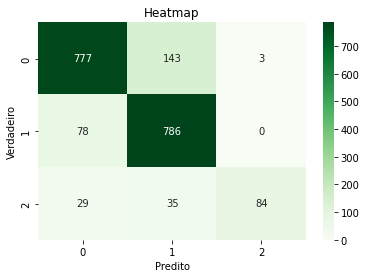

In [32]:
cm = confusion_matrix(y_test, y_cat_pred)
sns.heatmap(cm, annot = True, cmap = 'Greens', fmt = '.3g')
plt.title("Heatmap")
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.show()

In [33]:
print(classification_report(y_test, y_cat_pred))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86       923
           1       0.82      0.91      0.86       864
           2       0.97      0.57      0.71       148

    accuracy                           0.85      1935
   macro avg       0.89      0.77      0.81      1935
weighted avg       0.86      0.85      0.85      1935



**LINKS:**

1. https://arxiv.org/pdf/1405.4053.pdf

2. https://medium.com/@amarbudhiraja/understanding-document-embeddings-of-doc2vec-bfe7237a26da

3. https://aclanthology.org/W16-1609.pdf

4. https://heartbeat.fritz.ai/getting-started-with-doc2vec-2645e3e9f137

5. https://shuzhanfan.github.io/2018/08/understanding-word2vec-and-doc2vec/

6. http://dspace.unipampa.edu.br/bitstream/riu/1601/1/An%C3%A1lise%20de%20sentimento%20usando%20a%20representa%C3%A7%C3%A3o%20distribu%C3%ADda%20de%20par%C3%A1grafos%20para%20o%20portugu%C3%AAs.pdf
